In [1]:
import numpy as np
import pandas as pd
import random
pd.set_option('display.max_column', None)

import matplotlib.pyplot as plt
import seaborn as sns

import shap

import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Customer Segmentation Analysis

In this project, I will be performing a customer segmentation of clients that are regular customers of a fictional product. This example is given as follows: Imagine that this fictitious company wants to launch a new product on the market, which group of customers is the most suitable to promote the product?

The results that I am looking foward are:

- Segment the customers in distinct groups
- Explore the characteristics of each group
- Explore why the classification model assigned a customer to his group

The dataset that I will be using is generate by randon variables with some expected characteristics that could be provided by a generic company

In [2]:
# Generate 1000 random rows for the dataframe
random.seed(42)
data = []
sex = ["Female","Male"]
for i in range(1000):
    data.append({
        'sex': random.choice(sex),
        'age': random.randint(18, 75),
        'monthly_visits': random.randint(1, 45),
        'total_purchase_amount': random.randint(40000, 365000),
        'distinct_products' : random.randint(1,50),
        'monthly_purchases_avg' : random.randint(12,30),
        'avg_purchase_price': random.uniform(105.5,2500)
    })

df = pd.DataFrame(data)
df.avg_purchase_price = df.avg_purchase_price.round(2)
df.head()

,sex,age,monthly_visits,total_purchase_amount,distinct_products,monthly_purchases_avg,avg_purchase_price
0,Female,19,18,168393,15,16,1868.98
1,Female,55,28,56663,2,14,629.03
2,Female,53,13,325706,27,19,1181.13
3,Male,69,1,123707,45,25,920.23
4,Female,31,22,93587,6,24,337.09


The dataset contains data from users, here are the featuers:

- Age of the user
- Sex of the user
- How many visits in the last month
- Total purchases
- Distinct products bought
- Quantity of produts bought last month
- Average purchase price

Since the data was randon generated, there is no need to drop missing values

Let's have a look at the data's stats.

In [3]:
df.describe()

,age,monthly_visits,total_purchase_amount,distinct_products,monthly_purchases_avg,avg_purchase_price
count,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000
mean,46.64800,23.339000,206801.675000,24.86800,20.95800,1306.608990
std,16.16643,13.246114,94820.525363,14.36269,5.48017,680.096657
min,18.00000,1.000000,40048.000000,1.00000,12.00000,107.220000
25%,34.00000,11.000000,123729.500000,13.00000,16.00000,705.165000
50%,47.00000,24.000000,207569.000000,25.00000,21.00000,1317.395000
75%,61.00000,35.000000,289238.750000,37.00000,26.00000,1911.602500
max,75.00000,45.000000,364943.000000,50.00000,30.00000,2493.450000


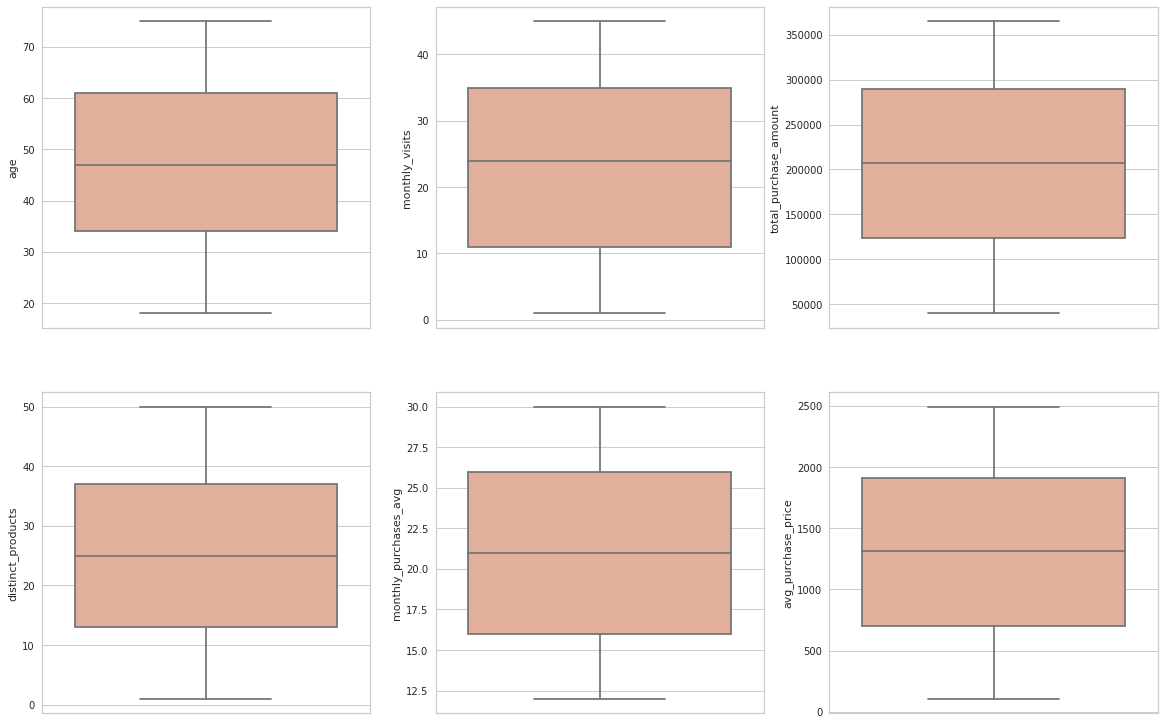

In [4]:
fig, axs = plt.subplots(ncols=3, nrows = 2)

sns.boxplot(y = df['age'], color= '#eea990', ax = axs[0,0])
sns.boxplot(y = df['monthly_visits'], color= '#eea990', ax = axs[0,1])
sns.boxplot(y = df['total_purchase_amount'], color= '#eea990', ax = axs[0,2])
sns.boxplot(y = df['distinct_products'], color= '#eea990', ax = axs[1,0])
sns.boxplot(y = df['monthly_purchases_avg'], color= '#eea990', ax = axs[1,1])
sns.boxplot(y = df['avg_purchase_price'], color= '#eea990', ax = axs[1,2])
fig.set_size_inches(20, 13)

<AxesSubplot:>

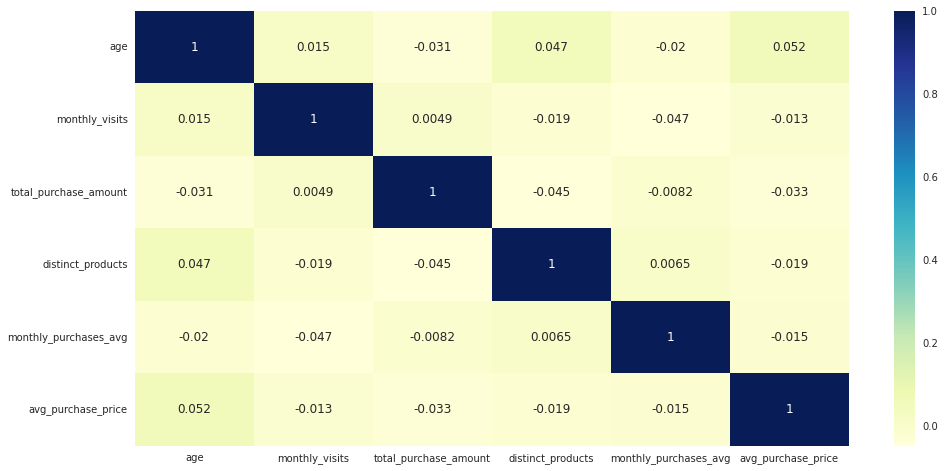

In [5]:
plt.figure(figsize= (16, 8))
sns.heatmap(df.corr(), annot = True, cmap= 'YlGnBu')

Since the data is random generated it is expected a low correlation between the variables, and a very well distributed dataset

## Data Preprocessing

Some transformations before modeling

1)Encoding categorical variables

2)Standard scaling all values

3)PCA to three dimensions

No Skew log required

In [6]:
df = pd.get_dummies(df)

In [7]:
df.head()

,age,monthly_visits,total_purchase_amount,distinct_products,monthly_purchases_avg,avg_purchase_price,sex_Female,sex_Male
0,19,18,168393,15,16,1868.98,1,0
1,55,28,56663,2,14,629.03,1,0
2,53,13,325706,27,19,1181.13,1,0
3,69,1,123707,45,25,920.23,0,1
4,31,22,93587,6,24,337.09,1,0


All features are now numeric

Standardize features by removing the mean and scaling to unit variance.

In [8]:
scaler = StandardScaler()
scaler.fit(df)

df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

In [9]:
df_scaled.head()

,age,monthly_visits,total_purchase_amount,distinct_products,monthly_purchases_avg,avg_purchase_price,sex_Female,sex_Male
0,-1.711066,-0.403263,-0.405270,-0.687402,-0.905169,0.827312,0.996008,-0.996008
1,0.516885,0.352053,-1.584191,-1.592978,-1.270304,-0.996797,0.996008,-0.996008
2,0.393110,-0.780921,1.254621,0.148514,-0.357467,-0.184594,0.996008,-0.996008
3,1.383310,-1.687301,-0.876775,1.402389,0.737937,-0.568408,-1.004008,1.004008
4,-0.968416,-0.101137,-1.194587,-1.314339,0.555370,-1.426274,0.996008,-0.996008


Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. 

In [10]:
pca = PCA(n_components=3)
pca.fit(df_scaled)
df_PCA = pd.DataFrame(pca.transform(df_scaled), columns=(["col1","col2", "col3"]))
df_PCA.describe()

,col1,col2,col3
count,1.000000e+03,1000.000000,1.000000e+03
mean,-3.552714e-18,0.000000,-1.421085e-17
std,1.416918e+00,1.048036,1.030141e+00
min,-1.601766e+00,-2.823510,-2.618739e+00
25%,-1.408496e+00,-0.714840,-7.654288e-01
50%,-1.220532e+00,0.004326,-1.698177e-02
75%,1.425161e+00,0.709390,7.284619e-01
max,1.608696e+00,2.824047,2.914815e+00


Visualizing the date before modeling

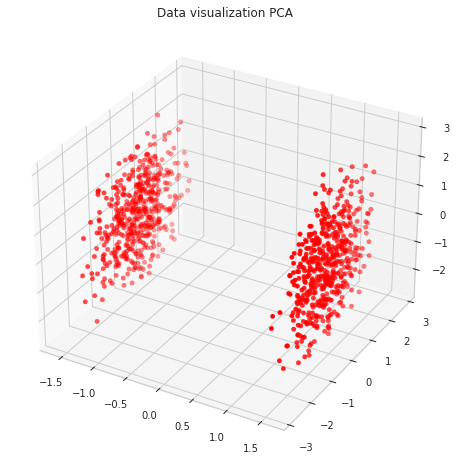

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df_PCA["col1"],df_PCA["col2"],df_PCA["col3"], c="red", marker="o")
ax.set_title("Data visualization PCA")
plt.show()

## Clustering

Utilizing a simple K-Means model for clustering

1)Finding k amount of clusters required

2)Adjusting dataset to model

3)Visualize results

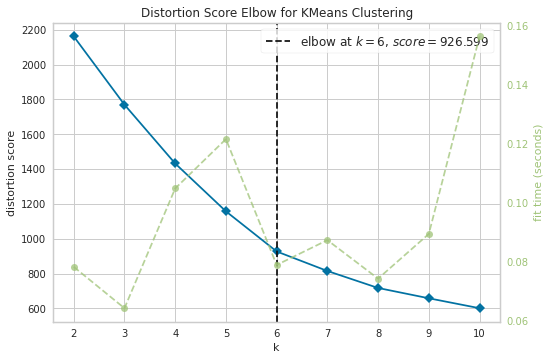

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
Elbow = KElbowVisualizer(KMeans(), k=10)
Elbow.fit(df_PCA)
Elbow.show()

By the elbow curve, it indicates that a good value for k is 6

In [13]:
AC = KMeans(n_clusters=6)
yhat_AC = AC.fit_predict(df_PCA)

df_PCA["Clusters"] = yhat_AC

To examine the clusters formed let's have a look at the 3-D distribution of the clusters

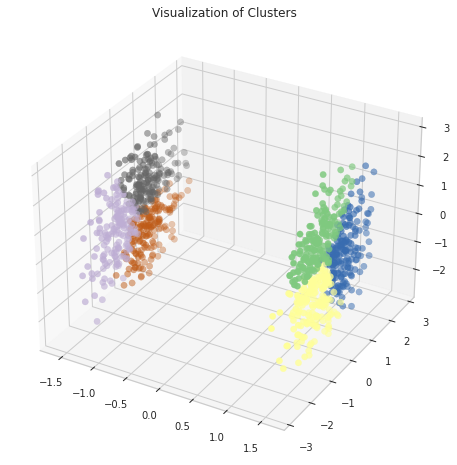

In [14]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(df_PCA["col1"],df_PCA["col2"],df_PCA["col3"], s=40, c=df_PCA["Clusters"], marker='o', cmap = "Accent")
ax.set_title("Visualization of Clusters")
plt.show()

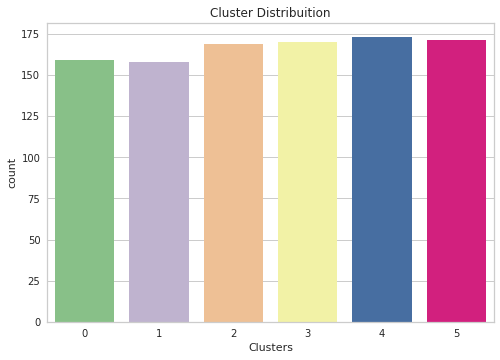

In [15]:
fig = sns.countplot(x=df_PCA["Clusters"], palette= "Accent")
fig.set_title("Cluster Distribuition")
plt.show()

let's have a look at the group distribution of clustring

In [16]:
df["Clusters"] = df_PCA.loc[:,"Clusters"].astype(int)

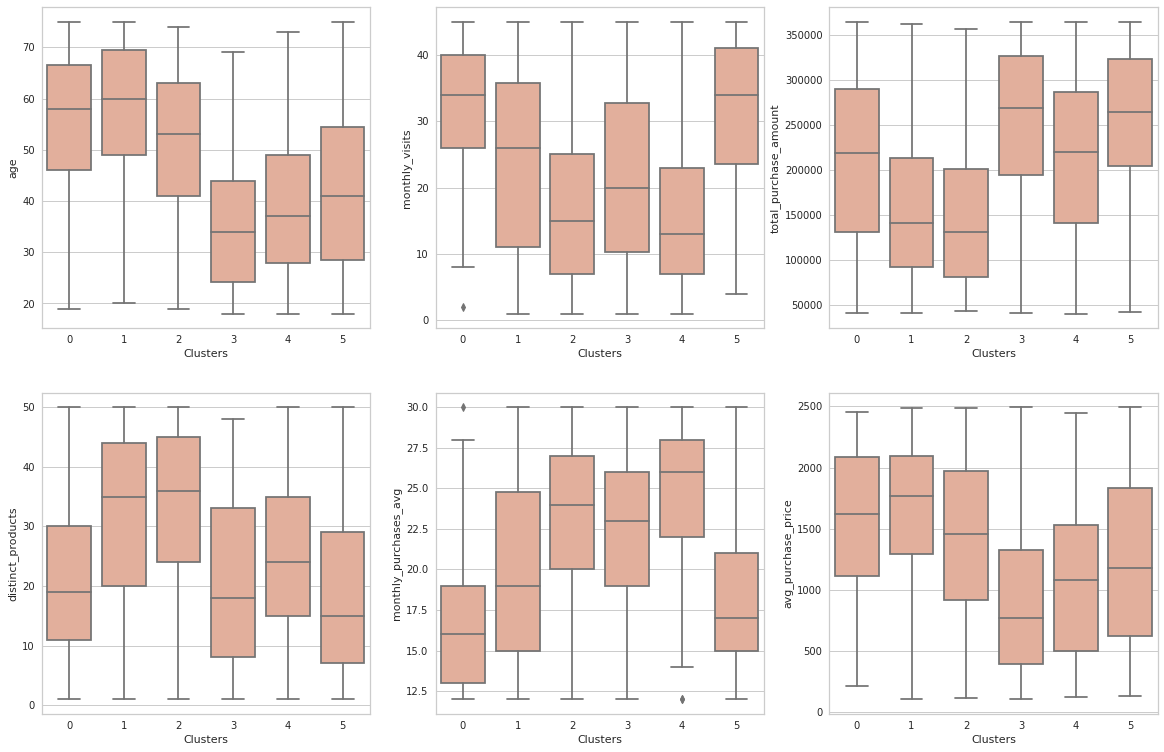

In [17]:
fig, axs = plt.subplots(ncols=3, nrows = 2)

sns.boxplot(y = df['age'], x = df['Clusters'], color= '#eea990', ax = axs[0,0])
sns.boxplot(y = df['monthly_visits'], x = df['Clusters'], color= '#eea990', ax = axs[0,1])
sns.boxplot(y = df['total_purchase_amount'], x = df['Clusters'], color= '#eea990', ax = axs[0,2])
sns.boxplot(y = df['distinct_products'], x = df['Clusters'], color= '#eea990', ax = axs[1,0])
sns.boxplot(y = df['monthly_purchases_avg'], x =df['Clusters'], color= '#eea990', ax = axs[1,1])
sns.boxplot(y = df['avg_purchase_price'], x = df['Clusters'], color= '#eea990', ax = axs[1,2])
fig.set_size_inches(20, 13)

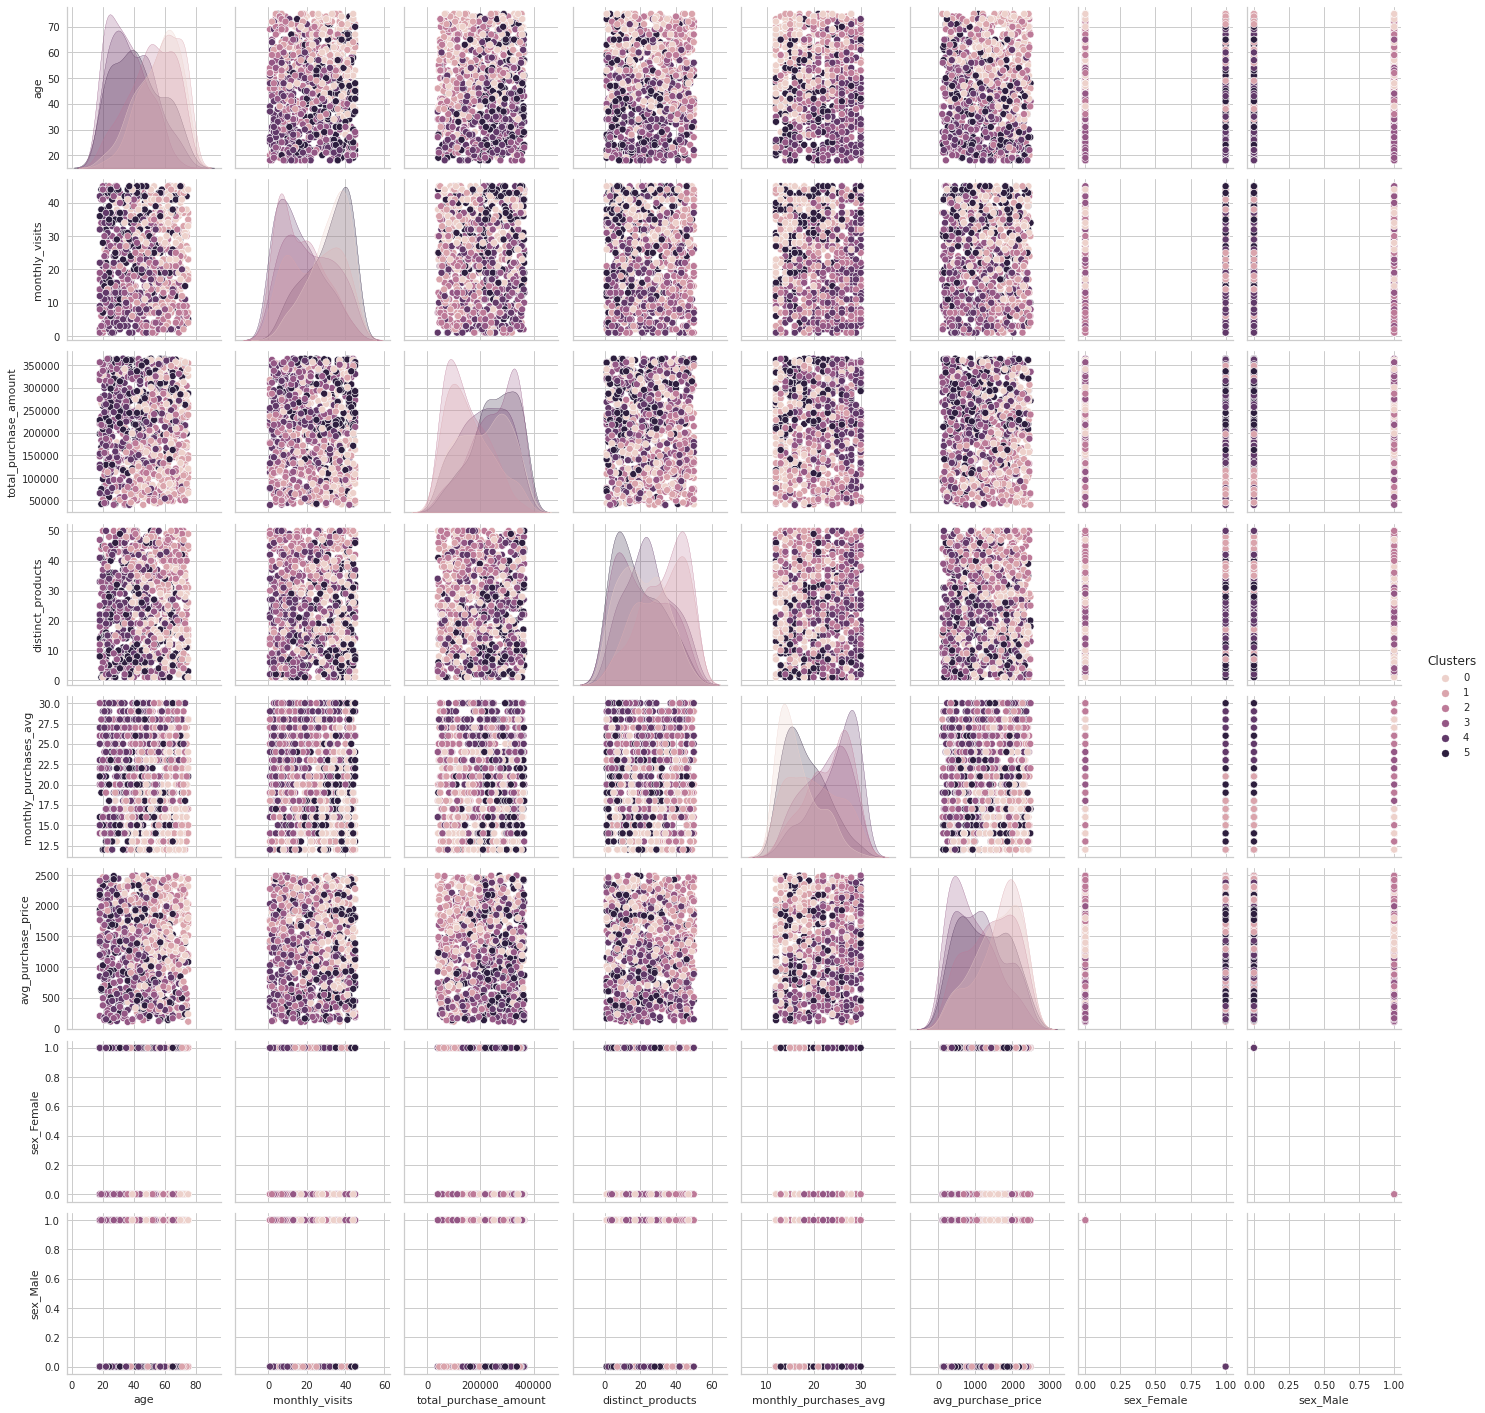

In [18]:
sns.pairplot(data = df, hue = "Clusters")

The clusters seems to bee farly distribuited

This is a table contaning some agregated data of the clusters generated, we can already see some well positioned clustering

In [19]:
df.pivot_table(index = 'Clusters',aggfunc = (['min','max','mean'])).T

Clusters                                0              1              2  \
min  age                        19.000000      20.000000      19.000000   
     avg_purchase_price        214.360000     111.650000     117.910000   
     distinct_products           1.000000       1.000000       1.000000   
     monthly_purchases_avg      12.000000      12.000000      12.000000   
     monthly_visits              2.000000       1.000000       1.000000   
     sex_Female                  0.000000       1.000000       0.000000   
     sex_Male                    1.000000       0.000000       1.000000   
     total_purchase_amount   41296.000000   40354.000000   42867.000000   
max  age                        75.000000      75.000000      74.000000   
     avg_purchase_price       2453.520000    2489.690000    2490.320000   
     distinct_products          50.000000      50.000000      50.000000   
     monthly_purchases_avg      30.000000      30.000000      30.000000   
     monthly_visits             45.000000      45.000000      45.000000   
     sex_Female                  0.000000       1.000000       0.000000   
     sex_Male                    1.000000       0.000000       1.000000   
     total_purchase_amount  364671.000000  361931.000000  357396.000000   
mean age                        55.132075      57.810127      51.473373   
     avg_purchase_price       1567.449434    1642.756392    1424.826509   
     distinct_products          20.748428      31.835443      33.331361   
     monthly_purchases_avg      16.641509      19.987342      23.183432   
     monthly_visits             31.635220      24.063291      16.597633   
     sex_Female                  0.000000       1.000000       0.000000   
     sex_Male                    1.000000       0.000000       1.000000   
     total_purchase_amount  212889.742138  159464.132911  146142.177515   

Clusters                                3              4              5  
min  age                        18.000000      18.000000      18.000000  
     avg_purchase_price        107.220000     121.850000     134.130000  
     distinct_products           1.000000       1.000000       1.000000  
     monthly_purchases_avg      12.000000      12.000000      12.000000  
     monthly_visits              1.000000       1.000000       4.000000  
     sex_Female                  0.000000       1.000000       1.000000  
     sex_Male                    1.000000       0.000000       0.000000  
     total_purchase_amount   40454.000000   40048.000000   42162.000000  
max  age                        69.000000      73.000000      75.000000  
     avg_purchase_price       2493.450000    2443.990000    2492.690000  
     distinct_products          48.000000      50.000000      50.000000  
     monthly_purchases_avg      30.000000      30.000000      30.000000  
     monthly_visits             45.000000      45.000000      45.000000  
     sex_Female                  0.000000       1.000000       1.000000  
     sex_Male                    1.000000       0.000000       0.000000  
     total_purchase_amount  364348.000000  364943.000000  364920.000000  
mean age                        35.376471      39.248555      42.368421  
     avg_purchase_price        914.677059    1114.241040    1220.903743  
     distinct_products          20.588235      24.653179      18.368421  
     monthly_purchases_avg      22.582353      24.705202      18.263158  
     monthly_visits             21.388235      15.861272      31.122807  
     sex_Female                  0.000000       1.000000       1.000000  
     sex_Male                    1.000000       0.000000       0.000000  
     total_purchase_amount  252886.123529  212787.057803  252959.315789

Going back to our problem, which group of customers would be the most fitted for the new product that is beeing created, could be solved by the pivot table above, looking at the data we can see some patterns for our groups resulting in a target for the product.

But we can go a little beyond, what if the product/market team wants to know how one group differ from another, in other words, what are the most important features that impact the classification for each cluster

## Classification

Utilizing a Random Forest with no pruning, to train a model based on K Means classification. By utilizing a Random Forest it is possible to apply a shap explainer and understand with variable had a bigger impact in the ouput of each cluster

In [20]:
df["Clusters"] = df_PCA.loc[:,"Clusters"]

In [21]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [23]:
classifier = RandomForestClassifier(criterion = 'entropy')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [24]:
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)
accuracy_score(y_test, y_pred)

[[32  0  2  3  0  0]
 [ 0 27  0  0  3  2]
 [ 2  0 30  3  0  0]
 [ 0  0  1 30  0  0]
 [ 0  0  0  0 28  1]
 [ 0  5  0  0  3 28]]


0.875

With the random forest classifier we got a R² of 0.875

Applying shap to see the impact of each feature on the classification model

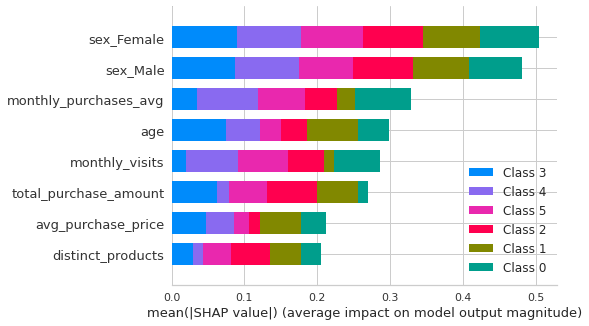

In [25]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X_train,feature_names = df.iloc[:, :-1].columns)

With shap values we can see that for Class 3 age have a bigger inpact than monthly_visits, with this logic we can analyse and create more impactfull insights over the classification

## Conclusion

In this project, I performed unsupervised clustering. I did use dimensionality reduction followed by Kmeans clustering. I came up with 6 clusters and further used them in a Random Forest Classifier to get a sense of metric score from the k Means, and then I Applyed Shap values to understand better how each feature inpact the segment of our clusters